<a href="https://colab.research.google.com/github/Meta-Sean/Practical-Deep-Learning/blob/main/tree_models_megasqueeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [4]:
df = pd.read_csv('Mega Squeeze.csv')
df.drop(['Date', 'Ticker', 'Name'], axis=1, inplace=True)
df = df.dropna()
df.columns

Index(['OS at time of run', 'Estimated float at time of run', 'Volume',
       'Close', 'High', 'Low', 'Open', 'Previous close',
       'Float value prior to run', 'Gap', 'Market cap prior to run',
       'Float rotation', 'High / Previous Close',
       'Possible Dilution at time of run', 'Notes', 'Reason for run',
       'Sector move'],
      dtype='object')

In [5]:
def proc_data(df):
  df['Possible Dilution at time of run'] = pd.Categorical(df['Possible Dilution at time of run'])
  df['Notes'] = pd.Categorical(df['Notes'])
  df['Reason for run'] = pd.Categorical(df['Reason for run'])
  df['Sector move'] = pd.Categorical(df['Sector move'])
  df['LogFloat'] = np.log1p(df['Estimated float at time of run'])

proc_data(df)

In [6]:
cats=["Possible Dilution at time of run", "Notes", "Reason for run", "Sector move"]
conts=['OS at time of run', 'LogFloat', 'Volume', 'Close', 'High', 'Low', 'Open', 'Previous close', 'Float value prior to run', 'Gap', 'Market cap prior to run', 'Float rotation']
dep='High / Previous Close'

In [7]:
df.Notes.head()

0                      Had shelf pending EFFECT
1    No dilution, offered after run through s-1
2                              Class B of LTRPA
3                                   No dilution
4                                   No dilution
Name: Notes, dtype: category
Categories (53, object): ['$10m Equlity line to Lincoln Park', '$10m shelf capacity due to baby shelf',
                          '$15m shelf capacity', '$1m in convertible notes', ...,
                          'Small equity line with volume restrictions', 'Spac warrants at $7.5',
                          'Spac warrants not exercisable until 30 days after close', 'Under baby shelf']

In [8]:
df.Notes.cat.codes.head()

0    28
1    35
2    22
3    32
4    32
dtype: int8

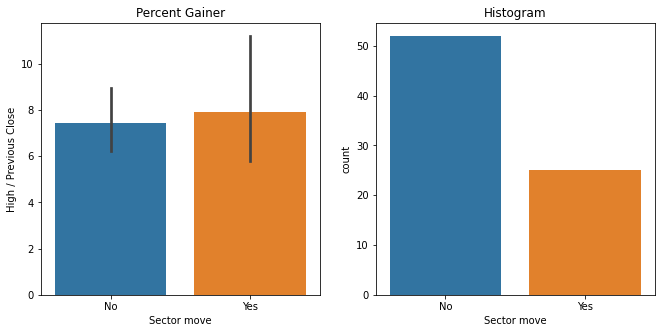

In [9]:
import seaborn as sns

fig, axs = plt.subplots(1, 2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="Sector move", ax=axs[0]).set(title="Percent Gainer")
sns.countplot(data=df, x="Sector move", ax=axs[1]).set(title="Histogram");

In [10]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df, val_df = train_test_split(df, test_size=0.25)
trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [11]:
def xs_y(df):
  xs = df[cats+conts].copy()
  return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [12]:
preds = val_xs['Sector move']=='Yes'

In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

8.955791413900002

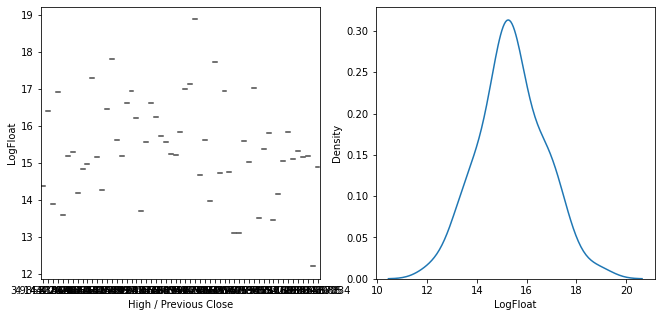

In [14]:
df_float = trn_df[trn_df['LogFloat']>0]
fig,axs = plt.subplots(1, 2, figsize=(11, 5))
sns.boxenplot(data=df_float, x=dep, y="LogFloat", ax=axs[0])
sns.kdeplot(data=df_float, x="LogFloat", ax=axs[1]);

In [15]:
preds = val_xs.LogFloat>15

In [16]:
mean_absolute_error(val_y, preds)

8.255791413900003

In [17]:
def _side_score(side, y):
  tot = side.sum()
  if tot<=1: return 0
  return y[side].std()*tot

In [18]:
def score(col, y, split):
  lhs = col<=split
  return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [19]:
trn_xs['Sector move']

30    0
40    0
39    0
16    0
65    0
54    0
31    0
7     0
62    1
44    0
73    0
49    1
76    0
19    0
64    0
25    0
42    0
13    0
55    1
3     0
17    0
38    0
8     0
61    1
6     1
36    1
70    0
56    0
46    1
75    0
15    0
27    1
41    0
26    1
48    0
24    0
43    1
69    0
57    0
11    1
32    0
72    1
59    0
63    0
67    0
37    0
29    0
1     0
52    0
21    0
2     0
23    0
20    1
60    1
71    0
14    0
51    1
Name: Sector move, dtype: int8

In [20]:
score(trn_xs['Sector move'], trn_y, 0.5)

4.498965438296939

In [21]:
score(trn_xs['LogFloat'], trn_y, 15)

4.144774424693334

In [22]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=15.5)(iscore);

interactive(children=(Dropdown(description='nm', options=('OS at time of run', 'LogFloat', 'Volume', 'Close', …

In [23]:
nm = 'OS at time of run'
col = trn_xs[nm]
unq = col.unique()
unq.sort()
unq

array([1.17449300e+06, 1.20000000e+06, 1.40000000e+06, 1.58200000e+06, 1.59400000e+06, 1.69000000e+06, 1.85000000e+06,
       3.06285000e+06, 3.81200000e+06, 4.42500000e+06, 4.50000000e+06, 4.58000000e+06, 4.75000000e+06, 5.13000000e+06,
       5.14000000e+06, 5.16000000e+06, 5.73000000e+06, 6.56000000e+06, 6.87600000e+06, 6.96057600e+06, 7.09900000e+06,
       7.41000000e+06, 7.55800000e+06, 7.76217700e+06, 7.77069800e+06, 8.07328900e+06, 8.55200000e+06, 8.80000000e+06,
       9.49777700e+06, 9.79000000e+06, 1.08980000e+07, 1.20200000e+07, 1.32240000e+07, 1.40058120e+07, 1.42700000e+07,
       1.45025970e+07, 1.48100000e+07, 1.51500000e+07, 1.54000000e+07, 1.66290000e+07, 2.04500000e+07, 2.09438460e+07,
       2.78280000e+07, 2.79020000e+07, 2.99595650e+07, 3.20000000e+07, 3.49000000e+07, 3.88812940e+07, 4.37335990e+07,
       4.48084550e+07, 5.38700000e+07, 6.04700000e+07, 7.04600000e+07, 7.24302304e+07, 1.00000000e+08, 1.01597998e+08,
       1.60000000e+08])

In [24]:
def min_col(df, nm):
  col, y = df[nm], df[dep]
  unq = col.dropna().unique()
  scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
  idx = scores.argmin()
  return unq[idx],scores[idx]

min_col(trn_df, "OS at time of run")

(1200000.0, 4.310548037078063)

In [25]:
cols = cats+conts
{o:min_col(trn_df, o) for o in cols}

{'Possible Dilution at time of run': (2, 4.054272911345758),
 'Notes': (21, 4.0719210630904685),
 'Reason for run': (11, 4.451324004467585),
 'Sector move': (0, 4.498965438296939),
 'OS at time of run': (1200000.0, 4.310548037078063),
 'LogFloat': (12.206077645517674, 3.789578421391356),
 'Volume': (19193188.0, 3.7958980216507765),
 'Close': (19.71, 2.8152467492668896),
 'High': (129.04, 2.3149720162485705),
 'Low': (4.8, 3.705401943950579),
 'Open': (4.4, 3.882514783816268),
 'Previous close': (4.32, 3.415648629332059),
 'Float value prior to run': (952000.0, 3.789578421391356),
 'Gap': (0.051524711, 4.551840001705564),
 'Market cap prior to run': (57699694.0, 4.413472005508832),
 'Float rotation': (6.514415545, 3.8130699876207914)}

In [32]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

m = DecisionTreeRegressor(max_leaf_nodes=10).fit(trn_xs, trn_y);

In [33]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

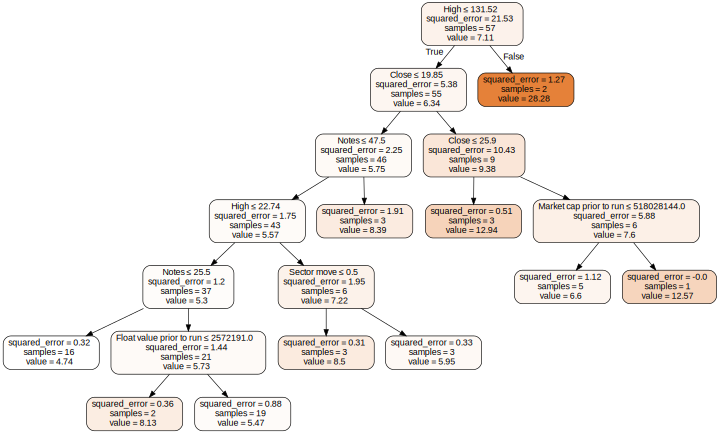

In [34]:
draw_tree(m, trn_xs, size=10)

In [29]:
trn_xs

,Possible Dilution at time of run,Notes,Reason for run,Sector move,OS at time of run,LogFloat,Volume,Close,High,Low,Open,Previous close,Float value prior to run,Gap,Market cap prior to run,Float rotation
30,3,26,40,0,1.015980e+08,17.727534,125000000.0,9.79,18.80,2.4050,2.4300,2.5800,1.290000e+08,-0.058140,2.621228e+08,2.500000
40,1,46,46,0,7.770698e+06,15.828981,445937420.0,8.28,10.77,2.7000,3.2100,1.6100,1.205771e+07,0.993789,1.251082e+07,59.543573
39,3,32,29,0,7.046000e+07,16.994814,126000000.0,5.13,5.49,0.8200,0.8500,0.8189,1.967817e+07,0.037978,5.769969e+07,5.243446
16,1,24,40,0,9.497777e+06,15.816991,1285824.0,26.80,55.00,6.2800,6.7100,5.9350,4.391900e+07,0.130600,5.636931e+07,0.173760
65,3,20,44,0,3.812000e+06,14.845130,24821030.0,6.25,13.00,2.6400,2.6400,2.4000,6.720000e+06,0.100000,9.148800e+06,8.864654
54,1,25,58,0,2.995956e+07,16.946648,18631390.0,1.21,2.40,0.4200,0.4620,0.4035,9.240150e+06,0.145000,1.208868e+07,0.813598
31,3,34,25,0,7.410000e+06,13.964272,25073496.0,58.00,69.79,14.1900,17.5200,10.0000,1.160395e+07,0.752000,7.410000e+07,21.607725
7,3,30,40,0,7.243023e+07,15.319588,257154.0,47.06,129.04,10.0000,10.0000,9.5100,4.279500e+07,0.051525,6.888115e+08,0.057145
62,3,37,39,1,9.790000e+06,15.158376,66256416.0,3.91,5.15,0.9500,1.0000,0.9300,3.561900e+06,0.075269,9.104700e+06,17.299325
44,3,32,34,0,6.876000e+06,15.738615,1515703.0,3.65,6.60,1.8000,2.9500,1.0000,6.842169e+06,1.950000,6.876000e+06,0.221524


In [35]:
def gini(cond):
  act = df.loc[cond, dep]
  return 1 - act.mean()**2 - (1-act).mean()**2

In [38]:
def get_tree(prop=0.75):
  n = len(trn_y)
  idxs = random.choice(n, int(n*prop))
  return DecisionTreeRegressor(min_samples_leaf=5).fit(trn_xs.iloc[idxs], trn_y.iloc[idxs])

In [39]:
trees = [get_tree() for t in range(100)]

In [40]:
all_probs = [t.predict(val_xs) for t in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(val_y, avg_probs)

3.572801446038214

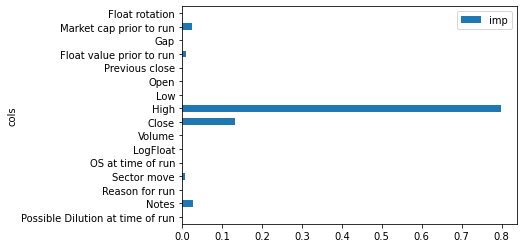

In [41]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=m.feature_importances_)).plot('cols', 'imp', 'barh')